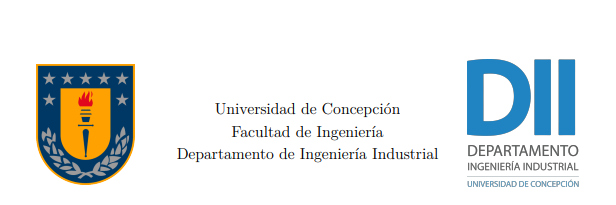

# Tarea 1 de optimización
## Mathias Badilla

#### Tarea sobre optimización de variante del problema del vendedor viajero Se adjunta el notebook donde se desarrolló la tarea correspondiente, incluye algunos comentarios y divisiones correspondientes para el caso. Espero disfruten la experiencia, saludos.

### Importando las librerias a utilizar. En este caso trabajaremos con 4.
### -Docplex
### -Numpy
### -Matplot
### -Time

In [1]:
from docplex.mp.model import Model
import matplotlib.pyplot as plt
import numpy as np
from time import time

### Dado que trabajaremos con archivos que contendrán los datos, definiremos una función de lectura que retornara una lista con los datos para cada seccion(Conjuntos, deposito, instalaciones,clientes y conexiones)

In [2]:
def lectura(txt):
    archivo=open(txt,'r')
    archivo=archivo.read()
    datos=archivo.split('\n\n')
    for i in range(len(datos)):
        datos[i]=datos[i].split('\n')
    conjuntos,deposito,instalaciones,clientes,conexiones=datos[0],datos[1][1].split(' '),datos[2],datos[3],datos[4]
    clientes.pop(0),conexiones.pop(0)
    for i in range(len(conjuntos)):
        conjuntos[i]=float(conjuntos[i])
    for i in range(len(deposito)):
        deposito[i]=float(deposito[i])
    for i in range(len(instalaciones)):
        aux=instalaciones[i].split(' ')
        for j in range(len(aux)):
            aux[j]=float(aux[j])
        instalaciones[i]=aux
    for i in range(len(clientes)):
        aux=clientes[i].split(' ')
        for j in range(len(aux)):
            aux[j]=float(aux[j])
        clientes[i]=aux
    for i in range(len(conexiones)):
        aux=conexiones[i].split(' ')
        aux.pop(len(aux)-1)
        for j in range(len(aux)):
            aux[j]=float(aux[j])
        conexiones[i]=aux
    conexiones.pop(len(conexiones)-1)
    return(conjuntos,deposito,instalaciones,clientes,conexiones)   

### En la siguiente funcion se definen los diversos parametros que se usaran durante el desarrollo del programa, entre ellos cabe mencionar los diversos arcos que en el caso de la variable "*x*" representa las convinaciones entre todas las instalaciones, y en el caso de la variable "*y*" las conexiones entre los clientes y las instalaciones (Respectivamente). En la linea 25 se usa una función de numpy que sirve para el calculo de las distancias entre los puntos.

In [3]:
def parametros(conjuntos,deposito,instalaciones,clientes,conexiones):
    n_instalaciones,n_clientes=int(conjuntos[1]),int(conjuntos[2])
    #Arcos de instalaciones
    v_instalaciones=[i for i in range(n_instalaciones+1)]
    arco_i=[(i,j) for i in v_instalaciones for j in v_instalaciones if i!=j]
    #Arcos de clientes
    v_clientes=[i+n_instalaciones+1 for i in range(n_clientes)]
    arco_c=[]
    for i in conexiones:
        for j in range(2,len(i)):
            arco_c.append((i[j],i[0]))
    #Coordenadas clientes
    clientes_x=[i[1] for i in clientes ]
    clientes_y=[i[2] for i in clientes ]
    #Coordenadas deposito
    dep_x=[deposito[1]]
    dep_y=[deposito[2]]
    #Coordenadas instalaciones
    instalaciones_x=[i[1] for i in instalaciones ]
    instalaciones_x=dep_x+instalaciones_x
    instalaciones_y=[i[2] for i in instalaciones ]
    instalaciones_y=dep_y+instalaciones_y

    #Calculo de distancia con numpy
    t={(i,j):np.hypot(instalaciones_x[i]-instalaciones_x[j],instalaciones_y[i]-instalaciones_y[j]) for i,j in arco_i}
    return(v_instalaciones,v_clientes,arco_i,arco_c,clientes_x,clientes_y,dep_x,dep_y,instalaciones_x,instalaciones_y,t,conjuntos)

# Funcion Objetivo_VariableS
### Aca se define la funcion objetivo de nuestro problema, y las variables que se usarán, estas se detallan de mejor manejra en el informe del problema

In [4]:
def fo_vs(arco_i,arco_c,v_instalaciones,t):
    mdl=Model('Modelo')
    #Crear variables
    x=mdl.binary_var_dict(arco_i,name='x') #arco de i a j pertenece
    y=mdl.binary_var_dict(arco_c,name='y') #cliente i abastecido por j
    z=mdl.binary_var_dict(v_instalaciones,name='z') #Vetice perteneciente 
    g=mdl.integer_var_dict(arco_i,name='g')
    #Función objetivo
    mdl.minimize(mdl.sum(x[i]*t[i] for i in arco_i))
    return(x,y,z,g,mdl)

### En la siguiente función se desarrollan las distintas restricciones, que de igual manera se explican mejor en el informe. Cabe destacar que cuando una restricción posee un "Para todo" se trabaja con un ciclo "for" dentro del parametro al que pertenece la variable

In [5]:
def restricciones(arco_c,arco_i,v_instalaciones,v_clientes,x,y,z,g,mdl,conjuntos):
    #Prender clientes
    for vj in v_instalaciones:
        mdl.add_constraint(mdl.sum(y[(i,j)]-z[j] for i,j in arco_c if j==vj )<=0)
    #Restriccion doble abastecedor
    for vi in v_clientes:
        mdl.add_constraint(mdl.sum(y[(i,j)] for i,j in arco_c if i==vi )<=1)
    #Beneficio mayor que p
    p=conjuntos[3]
    mdl.add_constraint(mdl.sum(y[(i,j)] for i,j in arco_c )>=p)
    #1 entrada 1 salida
    for vi in v_instalaciones:
        mdl.add_constraint(mdl.sum(x[(i,j)] for i,j in arco_i if i==vi )==z[vi])
        mdl.add_constraint(mdl.sum(x[(i,j)] for i,j in arco_i if j==vi )==z[vi])
    #Fija nodo 0 partida
    mdl.add_constraint(mdl.sum(g[(i,j)] for i,j in arco_i if i==0)==0)
    #Entrada y salida
    for vi in v_instalaciones:
        if(vi!=0):
            mdl.add_constraint(mdl.sum(g[(i,j)]-g[(j,i)] for i,j in arco_i if i==vi )==z[vi])
    #3ra G
    for i,j in arco_i:
        mdl.add_constraint(g[(i,j)] >=0)
        mdl.add_constraint(g[(i,j)]<=len(v_instalaciones)*x[(i,j)])

### Aquí se usan las funciones de docplex para resolver el problema propuesto

In [6]:
def solver(mdl):
    solucion=mdl.solve(log_output=True)
    mdl.get_solve_status()
    solucion.display()

### Usando las funciones de matplot se realiza el grafico de las instalaciones en conjunto con los clientes y el deposito

In [35]:
def graficar(arco_i,instalaciones_x,instalaciones_y,x,v_instalaciones,v_clientes,clientes_x,clientes_y,arco_c,y):
    arcos_solucion=[i for i in arco_i if x[i].solution_value>0.9]
    plt.figure(figsize=(24,16))
    plt.xlabel("Distancia X")
    plt.ylabel("Distancia Y")
    plt.title("Solución TSP")

    s=[]
    for i in range(len(v_instalaciones)):
        aux=[]
        aux.append("%.1f"%instalaciones_x[i])
        aux.append("%.1f"%instalaciones_y[i])
        s.append(aux)
    s_=[]
    for i in range(len(v_clientes)):
        aux=[]
        aux.append("%.1f"%clientes_x[i])
        aux.append("%.1f"%clientes_y[i])
        s_.append(aux)

    plt.scatter(x=instalaciones_x,y=instalaciones_y, color='blue',zorder=1)
    plt.scatter(x=clientes_x,y=clientes_y, color='c',zorder=1, marker='D' )
    for i,j in arcos_solucion:
        plt.plot([instalaciones_x[i],instalaciones_x[j]],[instalaciones_y[i],instalaciones_y[j]],color='blue',zorder=1)
    
    for i,j in arco_c:
        if(y[(i,j)].solution_value!=0):
            plt.plot([clientes_x[int(i)-len(v_instalaciones)],instalaciones_x[int(j)]],[clientes_y[int(i)-len(v_instalaciones)],instalaciones_y[int(j)]],color='c',zorder=1,linestyle = 'dashed')

    for i in range(len(v_instalaciones)):
        plt.annotate(str(i),xy=(instalaciones_x[i],instalaciones_y[i]),xytext=(instalaciones_x[i]+0.5,instalaciones_y[i]+1),color='red')
    

    plt.show()

### Finalemente definimos una funcion "main" que junte todas las funciones y así tener todo más ordenado

In [36]:
def __main__(i):
    conjuntos,deposito,instalaciones,clientes,conexiones=lectura(i)
    v_instalaciones,v_clientes,arco_i,arco_c,clientes_x,clientes_y,dep_x,dep_y,instalaciones_x,instalaciones_y,t,conjuntos=parametros(conjuntos,deposito,instalaciones,clientes,conexiones)
    x,y,z,g,mdl=fo_vs(arco_i,arco_c,v_instalaciones,t)
    restricciones(arco_c,arco_i,v_instalaciones,v_clientes,x,y,z,g,mdl,conjuntos)
    solver(mdl)
    graficar(arco_i,instalaciones_x,instalaciones_y,x,v_instalaciones,v_clientes,clientes_x,clientes_y,arco_c,y)

# Primer Caso

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 300 rows and 71 columns.
Reduced MIP has 280 rows, 506 columns, and 1451 nonzeros.
Reduced MIP has 281 binaries, 225 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.65 ticks)
Found incumbent of value 472.079517 after 0.02 sec. (3.34 ticks)
Probing time = 0.00 sec. (1.52 ticks)
Cover probing fixed 0 vars, tightened 70 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 rows and 20 columns.
MIP Presolve modified 74 coefficients.
Reduced MIP has 280 rows, 486 columns, and 1431 nonzeros.
Reduced MIP has 261 binaries, 225 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.21 ticks)
Probing time = 0.00 sec. (1.46 ticks)
Clique table members: 45.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynami

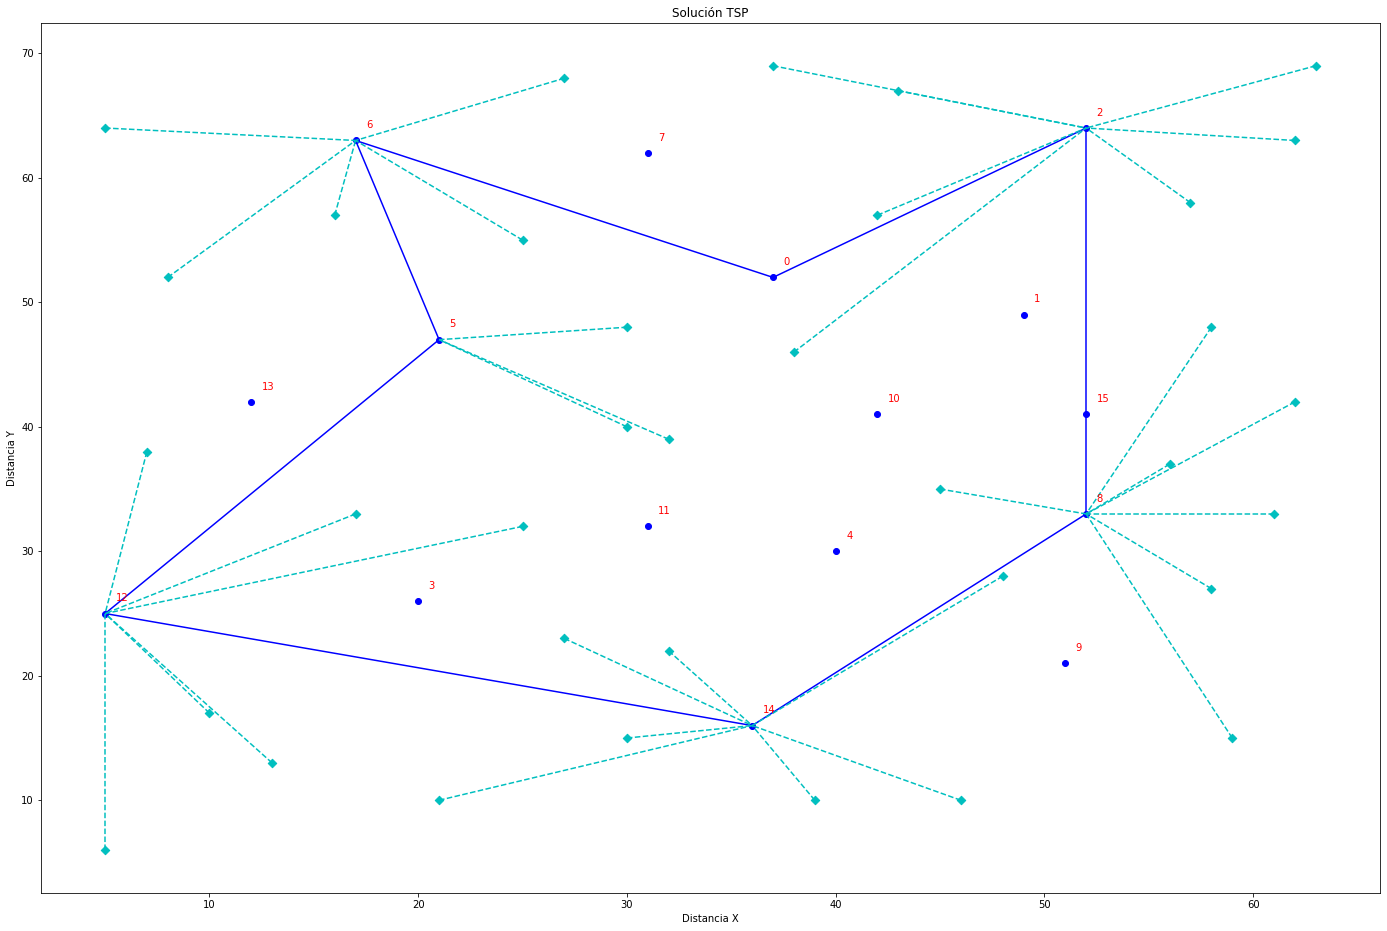

In [47]:
__main__('3.txt')

# Segundo caso

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 2 times.
MIP Presolve eliminated 678 rows and 25 columns.
MIP Presolve added 1 rows and 0 columns.
Aggregator did 1 substitutions.
Reduced MIP has 752 rows, 1438 columns, and 4289 nonzeros.
Reduced MIP has 813 binaries, 625 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.99 ticks)
Found incumbent of value 60.810448 after 0.02 sec. (9.49 ticks)
Probing time = 0.00 sec. (2.97 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 752 rows, 1438 columns, and 4289 nonzeros.
Reduced MIP has 813 binaries, 625 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.06 ticks)
Probing time = 0.00 sec. (2.91 ticks)
Clique table members: 213.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threa

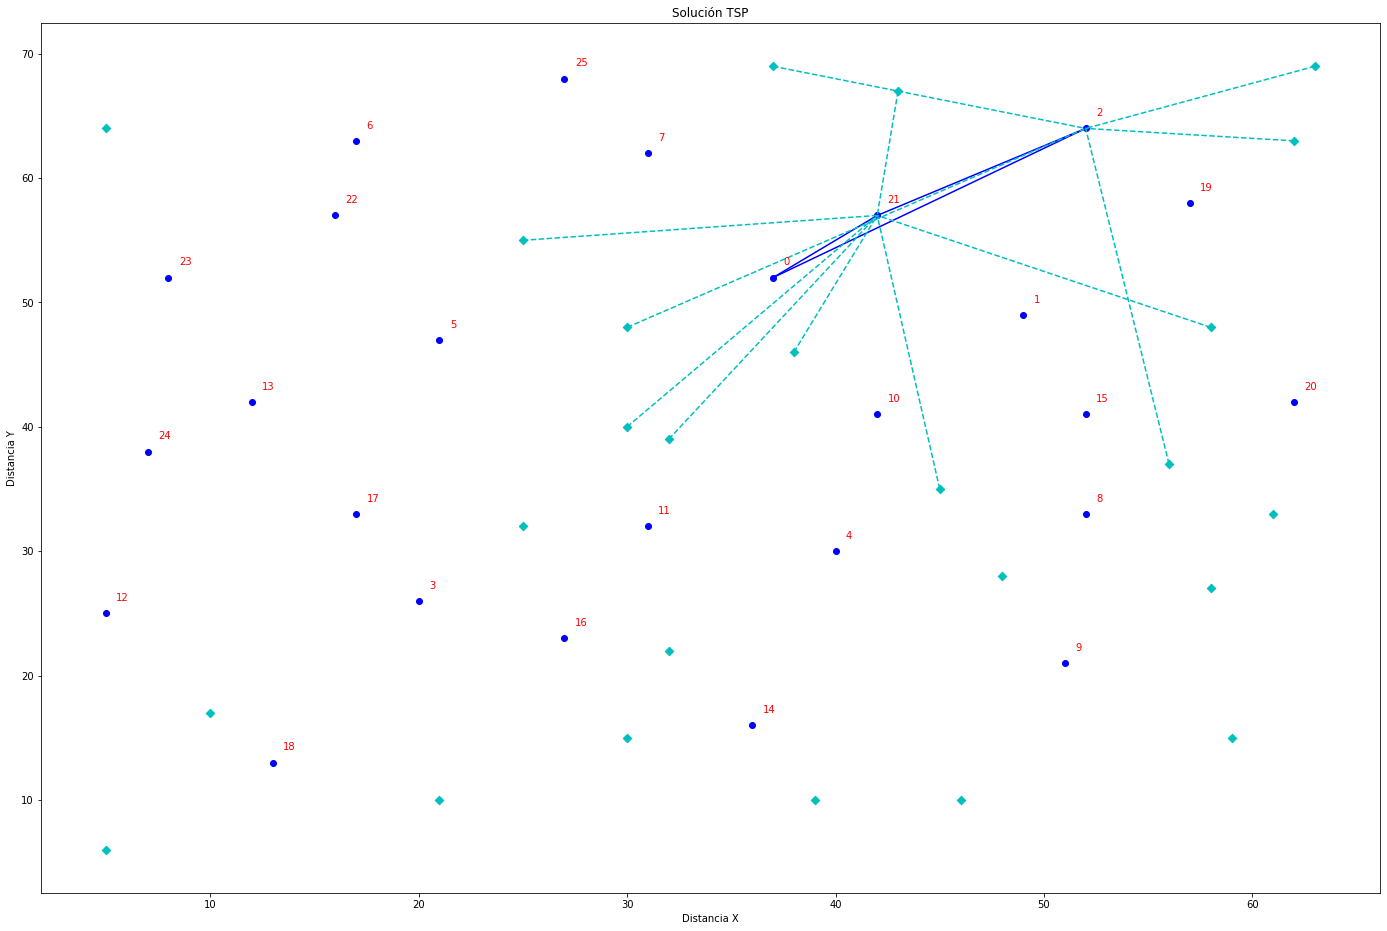

In [46]:
__main__('6.txt')

# Tercer caso

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 507 rows and 69 columns.
Reduced MIP has 536 rows, 993 columns, and 2923 nonzeros.
Reduced MIP has 552 binaries, 441 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.57 ticks)
Probing time = 0.00 sec. (2.77 ticks)
Cover probing fixed 0 vars, tightened 40 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 rows and 14 columns.
MIP Presolve modified 51 coefficients.
Reduced MIP has 536 rows, 979 columns, and 2909 nonzeros.
Reduced MIP has 538 binaries, 441 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.29 ticks)
Probing time = 0.00 sec. (2.69 ticks)
Clique table members: 114.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
R

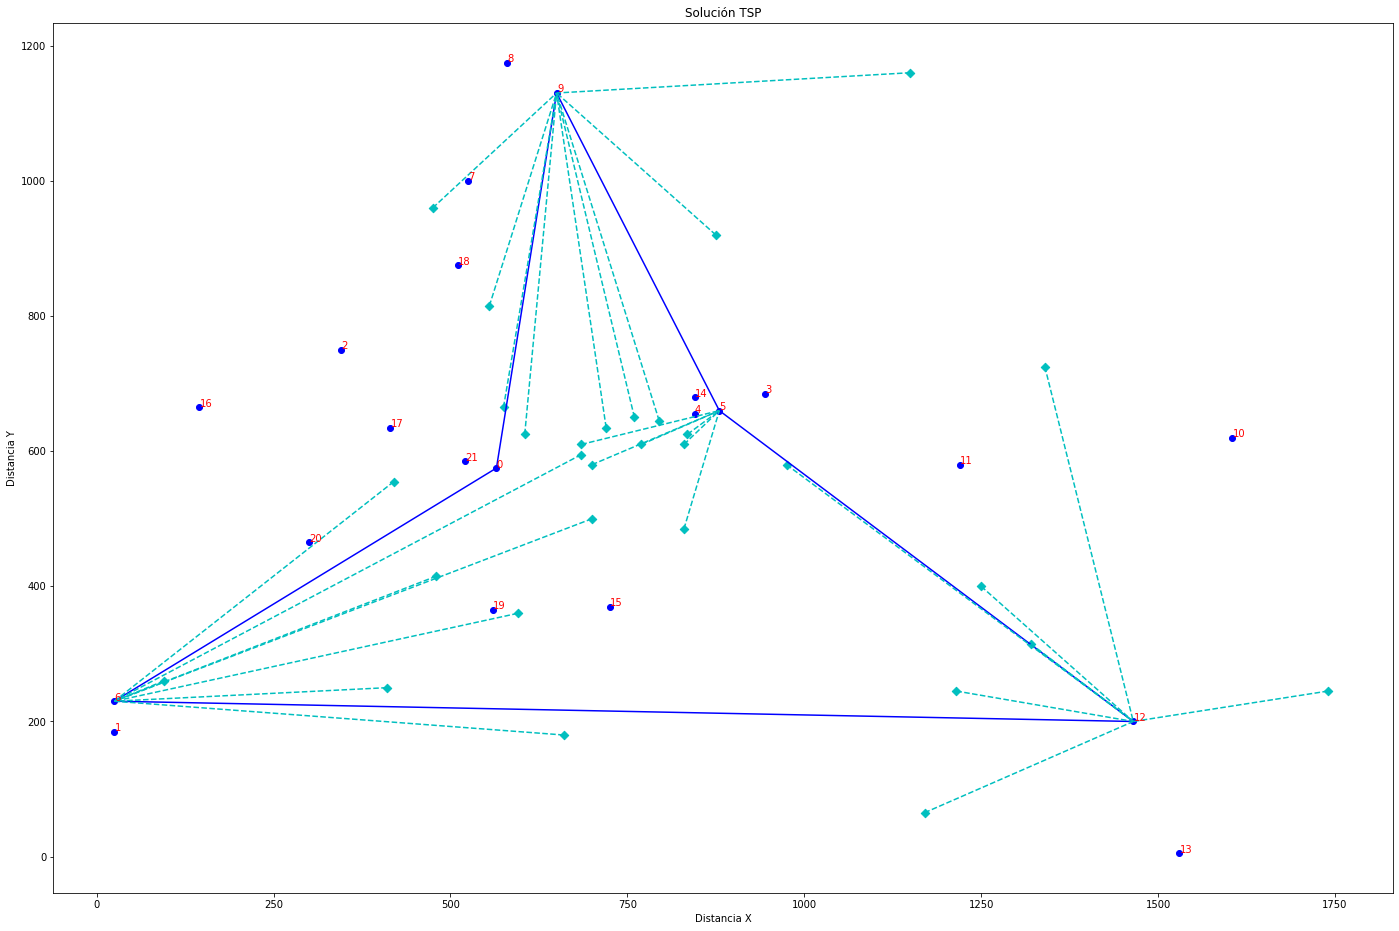

In [45]:
__main__('13.txt')

# Cuarto caso

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 1 time.
MIP Presolve eliminated 740 rows and 58 columns.
Reduced MIP has 798 rows, 1517 columns, and 4509 nonzeros.
Reduced MIP has 841 binaries, 676 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (3.40 ticks)
Probing time = 0.00 sec. (3.01 ticks)
Cover probing fixed 0 vars, tightened 25 bounds.
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 0 rows and 6 columns.
MIP Presolve modified 35 coefficients.
Reduced MIP has 798 rows, 1511 columns, and 4503 nonzeros.
Reduced MIP has 835 binaries, 676 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (3.46 ticks)
Probing time = 0.02 sec. (2.96 ticks)
Clique table members: 179.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.


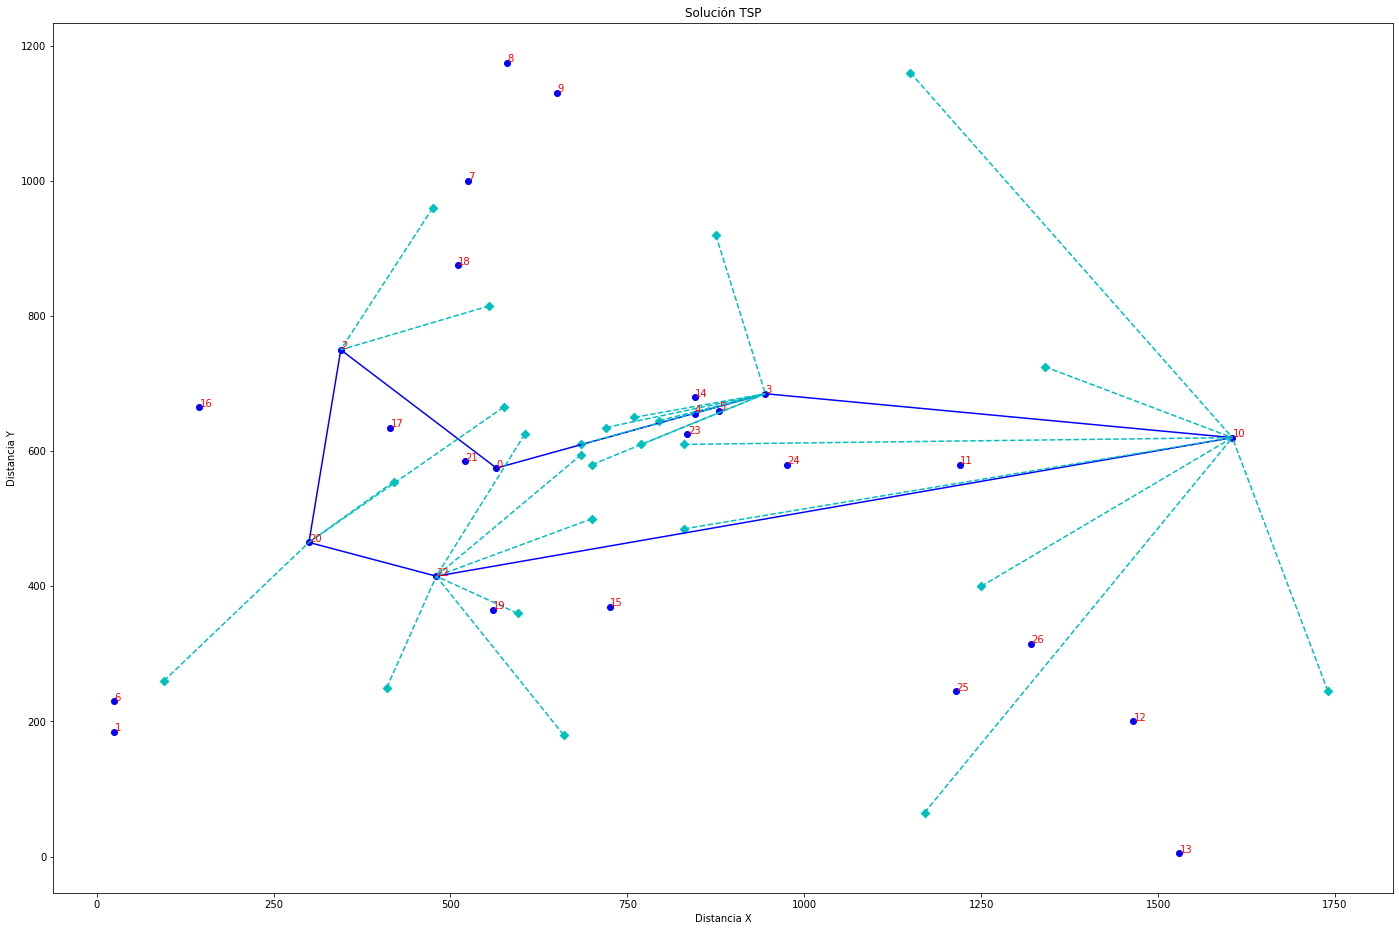

In [44]:
__main__('16.txt')

# Quinto caso

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de2ae
CPXPARAM_Read_DataCheck                          1
CPXPARAM_RandomSeed                              201903125
Tried aggregator 2 times.
MIP Presolve eliminated 593 rows and 29 columns.
MIP Presolve added 6 rows and 0 columns.
Aggregator did 6 substitutions.
Reduced MIP has 660 rows, 1214 columns, and 3624 nonzeros.
Reduced MIP has 685 binaries, 529 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.88 ticks)
Probing time = 0.00 sec. (2.87 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 660 rows, 1214 columns, and 3624 nonzeros.
Reduced MIP has 685 binaries, 529 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (2.63 ticks)
Probing time = 0.00 sec. (2.80 ticks)
Clique table members: 193.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.03 sec. (14.27 ticks)

   

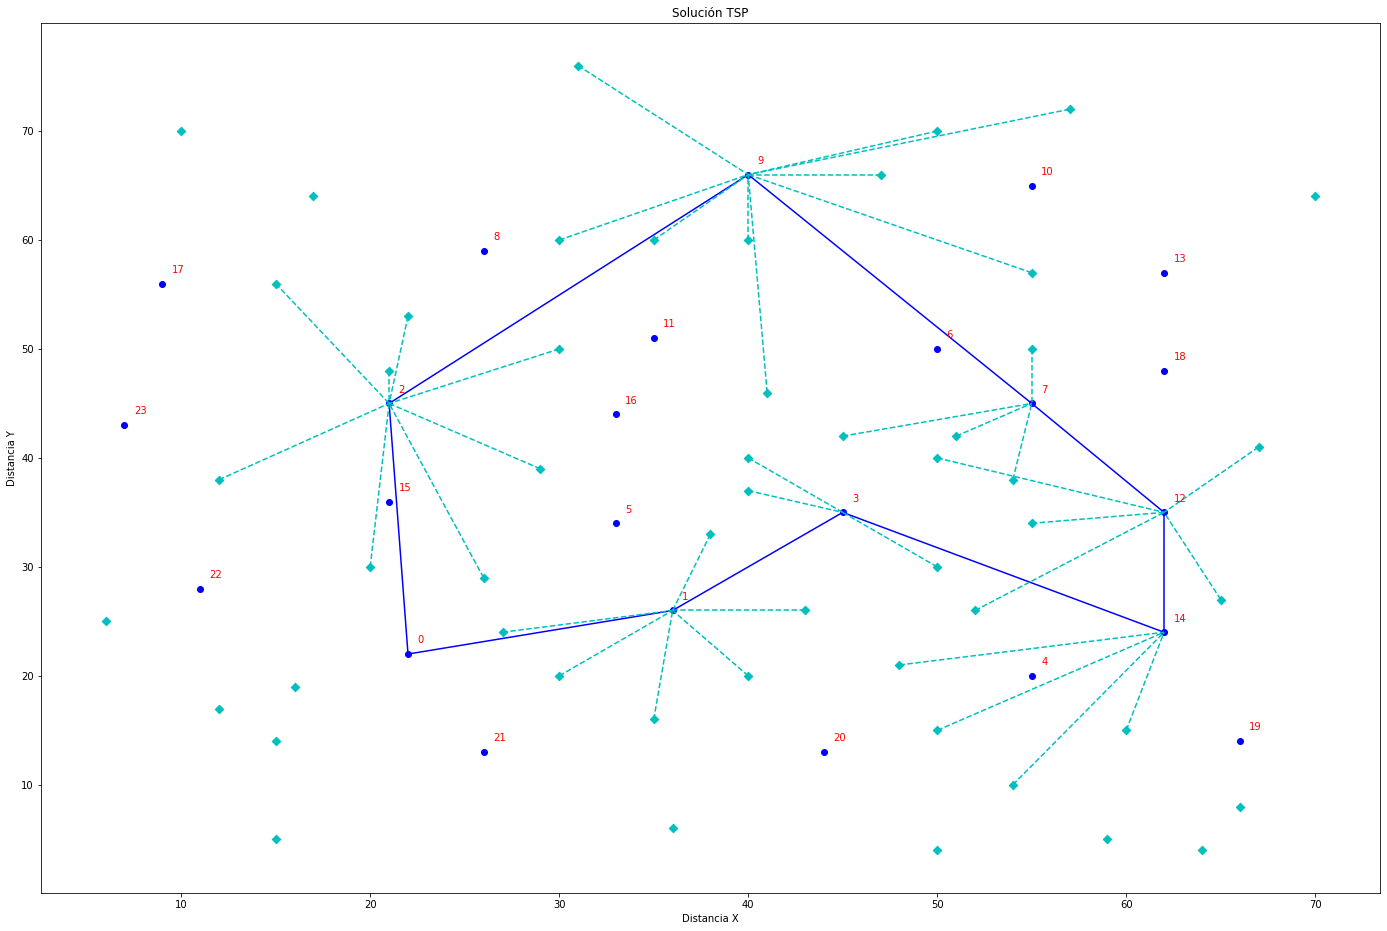

In [43]:
__main__('26.txt')